In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian
from jax.ops import index, index_update
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18
mpl.rcParams["font.family"] = "Times New Roman"

2021-09-10 16:01:56.888920: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.10.2'; dlerror: libcudart.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2021-09-10 16:01:57.404652: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.10.2'; dlerror: libcudart.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2021-09-10 16:01:57.414529: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.10.2'; dlerror: libcudart.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 


# Premiers pas

In [3]:
x = np.linspace(0 ,1 ,10) 
y = jnp.linspace(0 ,2 ,10)

2021-09-10 09:40:44.204117: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 
2021-09-10 09:40:44.204202: W external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
x,y

(array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 DeviceArray([0.        , 0.22222222, 0.44444445, 0.6666667 , 0.8888889 ,
              1.1111112 , 1.3333334 , 1.5555556 , 1.7777778 , 2.        ],            dtype=float32))

In [5]:
y[1] *= -1

TypeError: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/jax.ops.html

In [6]:
y = y.at[1].mul(-1)

In [7]:
y

DeviceArray([ 0.        , -0.22222222,  0.44444445,  0.6666667 ,
              0.8888889 ,  1.1111112 ,  1.3333334 ,  1.5555556 ,
              1.7777778 ,  2.        ], dtype=float32)

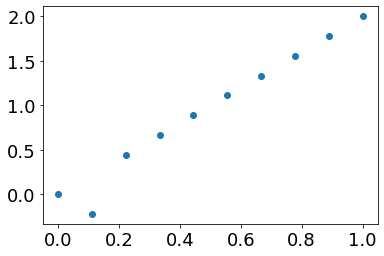

In [8]:
plt.scatter(x,y)

# Variations autour d'une fonction simple

## Dérivées successives

In [9]:
def f(x):
    return jnp.exp(-x*0.5)*jnp.sin(x)

In [10]:
def fp(x):
    return jnp.exp(-x*0.5)*(2.*jnp.cos(x)-jnp.sin(x))/2.
def fpp(x):
    return -jnp.exp(-x*0.5)*(4.*jnp.cos(x)+3.*jnp.sin(x))/4.

In [11]:
jfp  = jax.vmap(lambda t:grad(f)(t))
jfpp = jax.vmap(lambda t:grad(grad(f))(t))

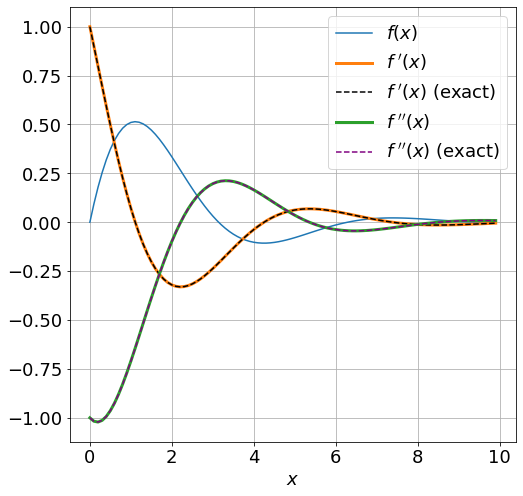

In [12]:
fig,_ = plt.subplots(figsize=(8,8))
x=jnp.arange(0,10,0.1)
plt.plot(x,f(x), label="$f(x)$")
plt.plot(x,jfp(x), lw=3,label="$f^{\ \prime}(x)$")
plt.plot(x,fp(x),ls="--",c='k', label="$f^{\ \prime}(x)$ (exact)")
plt.plot(x,jfpp(x), lw=3,label="$f^{\ \prime\prime}(x)$")
plt.plot(x,fpp(x),ls="--", c='purple',label="$f^{\ \prime\prime}(x)$ (exact)")
plt.grid()
plt.xlabel("$x$")
plt.legend();

## Fit simple

In [13]:
def f(p,x):
    return jnp.exp(-x*p[0])*jnp.sin(x*p[1])

In [14]:
ptrue = np.array([0.5,1])
ftrue = lambda x: f(ptrue, x)

In [16]:
xin = np.arange(0,10,1.)
yerr = 0.05
yin = ftrue(xin)+np.random.normal(scale=yerr,size=xin.shape)

In [17]:
def model(p, xi):
    return f(p,xi)

def mse(y_hat, y):
    return jnp.power(y_hat - y, 2).mean()

def loss_fun(p, xi, yi):
    yhat = model(p, xi)
    return mse(yhat, yi)

In [18]:
#@jit
def gradient_descent_step(p, xi, yi, lr=1e-1):
    return p - lr * jax.grad(loss_fun)(p, xi, yi)

In [19]:
def func(x, y):
    return 2 * x * y

print(grad(func)(3., 4.))  # 8.
print(grad(func, argnums=0)(3., 4.))  # 8.
print(grad(func, argnums=1)(3., 4.))  # 6
print(grad(func, argnums=(0, 1))(3., 4.))  # (8., 6.)

8.0
8.0
6.0
(DeviceArray(8., dtype=float32), DeviceArray(6., dtype=float32))


In [20]:
p_cur = jnp.array([0.1, 0.5])
rel_err=np.nan
for t in range(1000):

    if (t % 100) == 0:
        print(t, p_cur,rel_err)

    new_p = gradient_descent_step(p_cur, xin,yin)

    rel_err = jnp.sqrt(jnp.mean((p_cur - new_p)**2))
    if rel_err < 1e-9:
        print(f"Converged after {t} epochs: p = {new_p}")
        break

    p_cur = new_p

0 [0.1 0.5] nan
100 [0.4574501 0.8566841] 0.0007260848
200 [0.44926888 0.896838  ] 7.625353e-05
300 [0.44856405 0.9009106 ] 7.405892e-06
400 [0.44851232 0.9013086 ] 7.2143786e-07
500 [0.44850817 0.9013473 ] 8.4293696e-08
Converged after 545 epochs: p = [0.4485081  0.90135014]


## Méthode de Newton: le Hessien

In [21]:
gLoss = lambda p,xi,yi: jacfwd(loss_fun)(p,xi,yi)
hLoss = lambda p,xi,yi: jax.hessian(loss_fun)(p,xi,yi)

#@jit
def oneStepNewton(p,xi,yi,lr=0.1):
    return p - lr*jnp.linalg.inv(hLoss(p,xi,yi)) @ gLoss(p,xi,yi)

In [22]:
p_cur = jnp.array([0.1, 0.5])
rel_err=np.nan
for t in range(5000):

    if (t % 100) == 0:
        print(t, p_cur,rel_err)

    new_p = oneStepNewton(p_cur, xin,yin)

    rel_err = jnp.sqrt(jnp.mean((p_cur - new_p)**2))
    if rel_err < 1e-9:
        print(f"Converged after {t} epochs: p = {new_p}")
        break

    p_cur = new_p

0 [0.1 0.5] nan
100 [0.4484519 0.9013599] 4.434842e-06
Converged after 156 epochs: p = [0.4485075 0.9013517]


# Un autre type d'optimisation

In [23]:
# Volume de la boite 
def vol(x): 
    return x[0]*x[1]*x[2]
# Surface de la boite
def surf(x):
    return 2.*(x[0]*x[1]+x[0]*x[2]+x[1]*x[2])
# Constrainte sur la surface
def g(x): return surf(x) - 24

#Lagrangien : p[0:3] = (x1,x2,x3), p[3] = multiplicateur de lagrange
def Lag(p): 
    return vol(p[0:3]) - p[3]*g(p[0:3])

In [24]:
#Gradient Lagrangien
gLag = jacfwd(Lag)
hLag = hessian(Lag)
#@jit
def solveLagrangian(p,lr=0.1): 
    return p - lr*jnp.linalg.inv(hLag(p)) @ gLag(p)

In [25]:
p_cur = jnp.array([1.5,0.5,1.0,0.1])

for t in range(200):

    if (t % 10) == 0:
        print(t, p_cur)

    new_p = solveLagrangian(p_cur)
    
    rel_err = jnp.max(jnp.abs(p_cur - new_p))
    if rel_err < 1e-6:
        print(f"Converged after {t} epochs")
        break
    
    p_cur = new_p

p_fin=p_cur
v_fin = vol(p_fin[0:3])
s_fin = surf(p_fin[0:3])

print("p_fin: ",p_fin,": True x=y=z=2")
print("v_fin: ",v_fin,": True vol  = 2^3")
print("s_fin: ",s_fin,": True surf = 24")

0 [1.5 0.5 1.  0.1]
10 [1.8335831  1.5516778  1.7771686  0.40679324]
20 [1.9443337  1.8488717  1.9288238  0.46981663]
30 [1.9808731  1.9478556  1.9758338  0.48971188]
40 [1.9933647  1.9818827  1.9916482  0.49643993]
50 [1.9976906  1.9936905  1.9970968  0.49876192]
60 [1.9991952  1.997801   1.9989886  0.49956873]
70 [1.9997195  1.9992332  1.9996475  0.49984968]
80 [1.9999021  1.9997327  1.9998771  0.49994758]
90 [1.9999659  1.9999067  1.9999571  0.49998173]
100 [1.9999882  1.9999673  1.999985   0.49999362]
110 [1.999996   1.9999887  1.9999948  0.49999774]
Converged after 112 epochs
p_fin:  [1.9999967  1.9999908  1.9999957  0.49999818] : True x=y=z=2
v_fin:  7.999933 : True vol  = 2^3
s_fin:  23.999866 : True surf = 24


In [26]:
#@jit
def solveLagrangian(p,lr=0.01): 
    return p - lr*jnp.linalg.inv(hLag(p)) @ gLag(p)

vfuncsLAG = vmap(solveLagrangian)
key = jax.random.PRNGKey(0)
p_cur = jax.random.uniform(key, shape=(100,4), dtype='float32', minval=0., maxval=5.0)

In [27]:
for t in range(3000):
    p_cur = vfuncsLAG(p_cur)

In [28]:
maxfunc  = jax.vmap(vol)
maximums = maxfunc(p_cur)

In [29]:
arglist = jnp.nanargmax(maximums)
argmax = p_cur[arglist]
maxvol = maximums[arglist]
print(f"The max. volume is {maxvol:.6f}, the lengthes are ({argmax[0]:.6f},{argmax[1]:.6f},{argmax[2]:.6f})")

The max. volume is 8.000012, the lengthes are (2.000001,2.000001,2.000001)


# JIT: quelques exemples

Une chose qu'il est possible de faire pour se rendre compte de l'effet de JIT c'est de décommenter dans les cellules précédentes les lignes "@jit" (décorateur Python) et de réexecuter le notebook.

In [41]:
def simps(f, a, b, N):
    #N doit etre paire
    dx = (b - a) / N
    x = np.linspace(a, b, N + 1)
    y = f(x)
    w = np.ones_like(y)
    w[2:-1:2] = 2.
    w[1::2]   = 4.
    S = dx / 3 * np.einsum("i...,i...",w,y)
    return S

In [51]:
def funcN(x):
    return np.stack([x**(i/10) * np.exp(-x) for i in range(200)],axis=1)

In [52]:
a = np.arange(0,10,0.1)

In [53]:
b=a+0.05

In [63]:
b

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05,
       1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.15,
       2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85, 2.95, 3.05, 3.15, 3.25,
       3.35, 3.45, 3.55, 3.65, 3.75, 3.85, 3.95, 4.05, 4.15, 4.25, 4.35,
       4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25, 5.35, 5.45,
       5.55, 5.65, 5.75, 5.85, 5.95, 6.05, 6.15, 6.25, 6.35, 6.45, 6.55,
       6.65, 6.75, 6.85, 6.95, 7.05, 7.15, 7.25, 7.35, 7.45, 7.55, 7.65,
       7.75, 7.85, 7.95, 8.05, 8.15, 8.25, 8.35, 8.45, 8.55, 8.65, 8.75,
       8.85, 8.95, 9.05, 9.15, 9.25, 9.35, 9.45, 9.55, 9.65, 9.75, 9.85,
       9.95])

In [70]:
type(b[0])

numpy.float64

In [56]:
%timeit simps(funcN,a,b, 512)

1.13 s ± 27.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [94]:
tmp0 = simps(funcN,a,b, 512)

In [95]:
tmp0.shape

(200, 100)

In [97]:
from functools import partial
from jax.config import config
config.update("jax_enable_x64", True)

In [72]:
@partial(jit, static_argnums=(0,3))
def jax_simps(f, a,b, N):
    dx = (b - a) / N
    x = jnp.linspace(a, b, N + 1)
    y = f(x)
    w = jnp.ones_like(y)
    w = w.at[2:-1:2].set(2.)
    w = w.at[1::2].set(4.)
    S = dx / 3. * jnp.einsum('i...,i...',w,y)
    return S

In [77]:
@jit
def jax_funcN(x):
    return jnp.stack([x**(i/10) * jnp.exp(-x) for i in range(200)],axis=1)

In [78]:
ja = jnp.arange(0,10,0.1)
jb = ja+0.05

In [96]:
tmp1 = jax_simps(jax_funcN,ja,jb, 512).block_until_ready() 
%timeit jax_simps(jax_funcN,ja,jb, 512).block_until_ready() 

919 ms ± 38.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# JIT recompilation

In [168]:
def toto(x):
    print("toto recompile") # effet de bord
    return 2*x
@jit
def titi(x):
    print("titi recompile") # effet de bord
    return toto(x)

In [169]:
titi(0.)

titi recompile
toto recompile


DeviceArray(0., dtype=float64, weak_type=True)

In [170]:
titi(1.)

DeviceArray(2., dtype=float64, weak_type=True)

In [171]:
titi(1)

titi recompile
toto recompile


DeviceArray(2, dtype=int64, weak_type=True)

In [172]:
titi(2)

DeviceArray(4, dtype=int64, weak_type=True)

In [173]:
titi(5.)

DeviceArray(10., dtype=float64, weak_type=True)

## JIT et le contrôle "if-else"

In [5]:
@jit
def f(x,alpha=1.67, lambda_=1.05):
    if x>0:
        return lambda_*x
    else:
        return lambda_*alpha*(jnp.exp(x) -1)


In [9]:
f(1.)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
The problem arose with the `bool` function. 
While tracing the function f at /tmp/ipykernel_4111/3594871729.py:1 for jit, this concrete value was not available in Python because it depends on the value of the argument 'x'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [7]:
@jit
def fok(x,alpha=1.67, lambda_=1.05):
        return lambda_*jnp.where(x>0,x,alpha*(jnp.exp(x) -1))

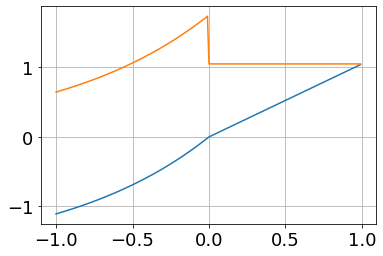

In [123]:
x = jnp.arange(-1,1,0.01)
plt.plot(x,vmap(fok)(x))
plt.plot(x,vmap(grad(fok))(x)) # le gradient...
plt.grid();

In [12]:
#version Numpy
def npok(x,alpha=1.67, lambda_=1.05):
        return lambda_*np.where(x>0,x,alpha*(np.exp(x) -1))

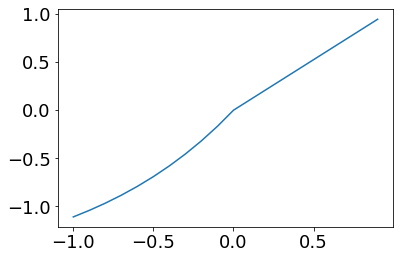

In [17]:
x = np.arange(-1,1,0.1)
plt.plot(x,np.vectorize(npok)(x))

In [116]:
@partial(jit, static_argnums=(0,))
def f_bof(x,alpha=1.67, lambda_=1.05):
    print(x)
    if x>0:
        return lambda_*x
    else:
        return lambda_*alpha*(jnp.exp(x) -1)


In [119]:
f_bof(0.5)

0.5


DeviceArray(0.525, dtype=float64, weak_type=True)

In [117]:
x = jnp.array([-0.5,0.,0.5])
f_bof(x)

ValueError: Non-hashable static arguments are not supported. An error occured while trying to hash an object of type <class 'jaxlib.xla_extension.DeviceArray'>, [-0.5  0.   0.5]. The error was:
TypeError: unhashable type: 'DeviceArray'


In [120]:
grad(f_bof)(0.5)

ValueError: Non-hashable static arguments are not supported. An error occured while trying to hash an object of type <class 'jax.interpreters.ad.JVPTracer'>, Traced<ConcreteArray(0.5, dtype=float64, weak_type=True)>with<JVPTrace(level=2/0)>
  with primal = Traced<ConcreteArray(0.5, dtype=float64, weak_type=True):JaxprTrace(level=1/0)>
       tangent = Traced<ShapedArray(float64[], weak_type=True):JaxprTrace(level=1/0)>. The error was:
TypeError: unhashable type: 'JVPTracer'


# JIT est la boucle for-loop

In [145]:
@jit
def root(x):
    val = x
    for i in range(0,10):
        val = (val+x/val)/2.
    return val

@jit
def jax_root(x):
    def body(i,val):
        return (val+x/val)/2.
    return jax.lax.fori_loop(0,10,body,x)
    

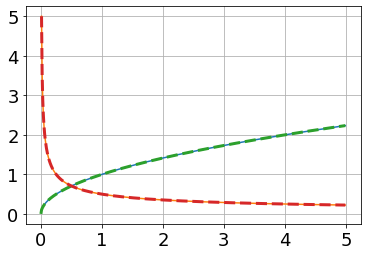

In [159]:
x = jnp.arange(0,5,0.01)
plt.plot(x, root(x))
plt.plot(x, vmap(grad(root))(x))
plt.plot(x, jnp.sqrt(x), lw=3,ls='--')
plt.plot(x, 1/(2*jnp.sqrt(x)), lw=3,ls='--')
plt.grid();

In [160]:
%timeit root(x)

7.92 µs ± 83.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [162]:
%timeit vmap(grad(root))(x)

6.23 ms ± 360 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [163]:
%timeit jax_root(x)

8.54 µs ± 248 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [164]:
%timeit  vmap(grad(jax_root))(x)

2.34 ms ± 171 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Profiling

In [174]:
import jax.profiler